# Kaggle Competition to identify Dogs vs Cats

https://www.kaggle.com/c/dogs-vs-cats

```csv
id,label
1,0
2,0
3,0
```

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = "data/dogscats/"
sz=224

In [4]:
PATH

'data/dogscats/'

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.backends.cudnn.enabled

True

In [7]:
os.listdir(PATH)

['tmp', 'test1', 'valid', 'models', 'train', 'sample']

We'll first look at the validation set

In [8]:
os.listdir(f'{PATH}valid')

['cats', 'dogs']

Let's take a look at some random dog and cat pics

In [9]:
cat_files = os.listdir(f'{PATH}valid/cats')

In [10]:
len(cat_files)

1000

In [11]:
dog_files = os.listdir(f'{PATH}valid/dogs')

In [12]:
len(dog_files)

1000

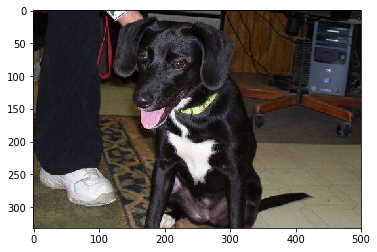

In [58]:
# img = plt.imread(f'{PATH}valid/cats/{cat_files[0]}')
# plt.imshow(img);
img = plt.imread(f'{PATH}test1/11835.jpg')
plt.imshow(img);

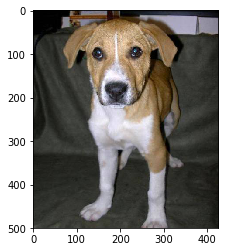

In [14]:
img = plt.imread(f'{PATH}valid/dogs/{dog_files[0]}')
plt.imshow(img);

We'll begin by using a pre-trained model Resnet34.
Let's use the pre-computed activations of
**resnet34** and run **2 epocs** with a **learning rate of 0.01**
```python
learn.fit(0.01, 2)
```

Why?
We want this to run fast so 2-3 epocs and 0.01 seem like sensible defaults.

In [15]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.042157   0.026572   0.99      
    1      0.041201   0.026626   0.9885                       



[array([0.02663]), 0.9885]

We're already getting a 99.2% accuracy!

Now let's look at the mis-classification by making predictions of the validation and see which ones are incorrect.

In [33]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [35]:
log_preds[1]

array([-0.0053 , -5.24291], dtype=float32)

In [19]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [20]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
        
def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))
    

In [21]:
rand_by_correct(False)

array([ 705, 1698, 1593,  618])

In [36]:
# idx = 
# title_probs = [probs[x] for x in idxs]
# title_probs

probs

array([0.00002, 0.00528, 0.0001 , ..., 0.99999, 0.99966, 0.05713], dtype=float32)

Incorrectly classified


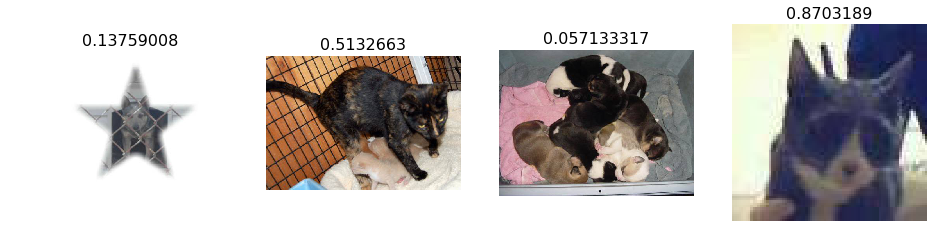

In [37]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

Now follow our recipe to optimize

1. precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting

In [23]:
learn.lr_find()

 75%|███████▍  | 269/360 [00:04<00:01, 55.65it/s, loss=0.0925]


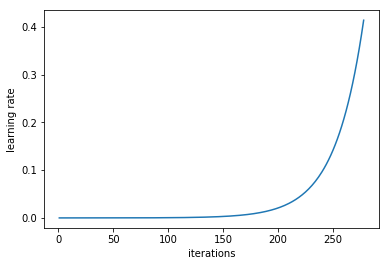

In [24]:
learn.sched.plot_lr()

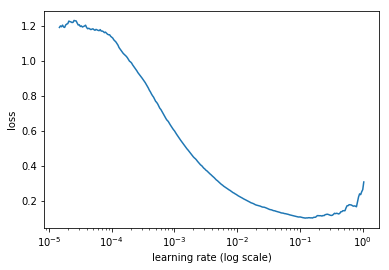

In [83]:
learn.sched.plot()

In [41]:
# Train last layer from precomputed activations for 1-2 epochs
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 3)

epoch      trn_loss   val_loss   accuracy                     
    0      0.046933   0.026502   0.991     
    1      0.042403   0.028863   0.9895                       
    2      0.034925   0.028514   0.9905                       



[array([0.02851]), 0.9905]

In [16]:
# Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
learn.precompute = False
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
# data = ImageClassifierData.from_paths(PATH, tfms=tfms)

In [43]:
learn.fit(0.01, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.039133   0.027545   0.989     
    1      0.043338   0.02526    0.992                        
    2      0.039366   0.026337   0.991                        
    3      0.035663   0.0273     0.9905                       
    4      0.037681   0.025063   0.991                        
    5      0.033348   0.024427   0.991                        
    6      0.034759   0.024574   0.991                        



[array([0.02457]), 0.991]

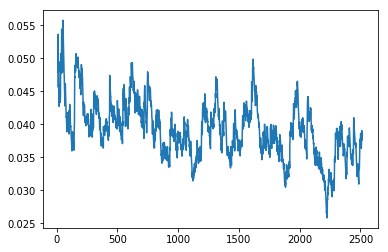

In [45]:
learn.sched.plot_loss()

In [46]:
learn.save('224_lastlayer')
learn.load('224_lastlayer')
learn.unfreeze()
lr=np.array([1e-4,1e-3,1e-2])

In [47]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.050925   0.028141   0.989     
    1      0.033497   0.02355    0.992                        
    2      0.032227   0.022758   0.9915                       
    3      0.023376   0.02095    0.993                        
    4      0.023982   0.018132   0.993                        
    5      0.027162   0.016803   0.9935                       
    6      0.022522   0.017295   0.992                        



[array([0.01729]), 0.992]

In [48]:
learn.save('224_all')
learn.load('224_all')

In [49]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [50]:
accuracy_np(probs, y)

0.994

In [18]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms, test_name='test1')
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.load('224_all')
log_preds,y = learn.TTA(is_test=True)

In [28]:
probs = np.mean(np.exp(log_preds),0)
preds = np.argmax(probs, axis=1)

In [49]:
index_preds = [index_pred for index_pred in preds]
index_preds

fnames = [re.sub('.jpg', '', fname[6:]) for fname in data.test_ds.fnames]
fname_preds = list(zip(fnames, index_preds))

In [54]:
df = pd.DataFrame(fname_preds)
df.columns = ['id', 'label']
df.to_csv(f'{PATH}submission.csv', index=False)

[[989  11]
 [  5 995]]


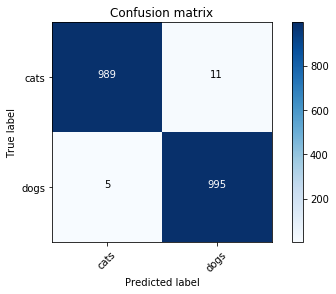

In [93]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)


plot_confusion_matrix(cm, data.classes)

Most incorrect cats


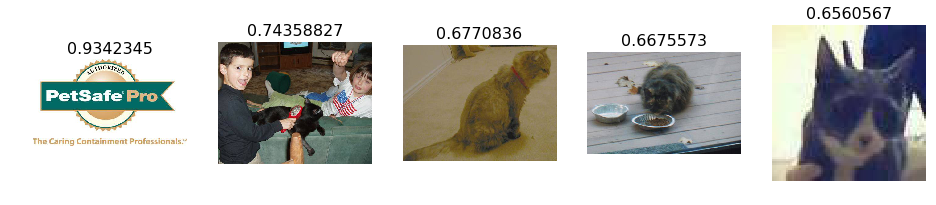

In [98]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:5]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


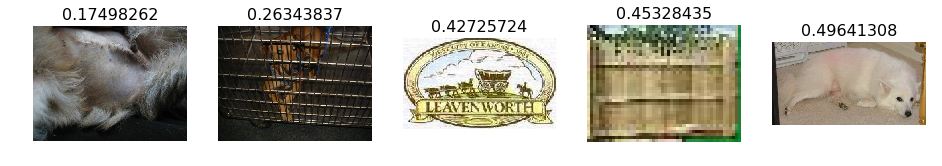

In [99]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

In [100]:
data.classes

['cats', 'dogs']

In [101]:
probs

array([0.     , 0.00002, 0.00019, ..., 1.     , 0.99998, 0.93597], dtype=float32)

In [102]:
data.val_y

array([0, 0, 0, ..., 1, 1, 1])